/tmp/ipython-input-3782985857.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["datetime"] = pd.to_datetime(data["datetime"], errors="coerce")
/tmp/ipython-input-3782985857.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["pm25"]


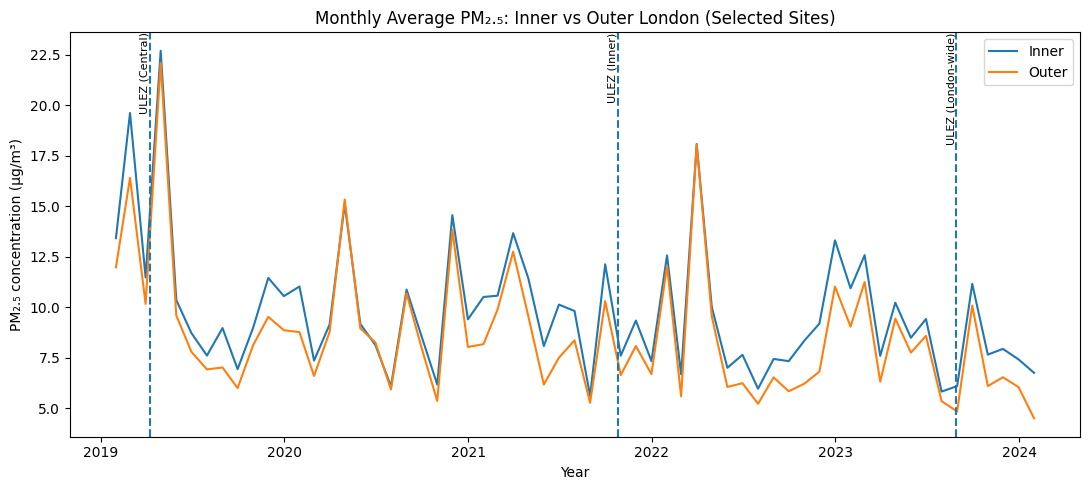

Rows used: 13456
Date range: 2019-01-01 00:00:00 to 2024-01-01 00:00:00

Observations per site:
site
London Honor Oak Park     1810
London Harlington         1801
London Bexley             1713
London Westminster        1615
London Marylebone Road    1567
Camden Kerbside           1560
London Eltham             1426
London Bloomsbury         1373
London Hillingdon          591
Name: count, dtype: int64


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt


RAW_PATH = "Pm2.5 (2).csv"


INNER_SITES = [
    "Camden Kerbside",
    "London Bloomsbury",
    "London Hillingdon",
    "London Honor Oak Park",
    "London Marylebone Road",
    "London Westminster"
]

OUTER_SITES = [
    "London Bexley",
    "London Eltham",
    "London Harlington"
]

ULEZ_LINES = [
    ("2019-04-08", "ULEZ (Central)"),
    ("2021-10-25", "ULEZ (Inner)"),
    ("2023-08-29", "ULEZ (London-wide)"),
]


raw = pd.read_csv(RAW_PATH, low_memory=False)
raw = raw.dropna(axis=1, how="all")

site_row = raw.iloc[2]


data = raw.iloc[5:].copy()


new_cols = []
for col, site in zip(data.columns, site_row):
    if pd.notna(site) and str(site).strip() != "":
        new_cols.append(str(site).strip())
    else:
        new_cols.append(col)
data.columns = new_cols


data.rename(columns={data.columns[0]: "datetime"}, inplace=True)
data["datetime"] = pd.to_datetime(data["datetime"], errors="coerce")
data = data.dropna(subset=["datetime"])


value_cols = [
    c for c in data.columns
    if c != "datetime" and "Status" not in str(c)
]

for c in value_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")


tidy = data.melt(
    id_vars="datetime",
    value_vars=value_cols,
    var_name="site",
    value_name="pm25"
).dropna(subset=["pm25"])



SITE_AREA = {s: "Inner" for s in INNER_SITES}
SITE_AREA.update({s: "Outer" for s in OUTER_SITES})

tidy = tidy[tidy["site"].isin(SITE_AREA.keys())].copy()
tidy["area"] = tidy["site"].map(SITE_AREA)



monthly = (
    tidy
    .set_index("datetime")
    .groupby(["area", "site"])
    .resample("M")["pm25"]
    .mean()
    .reset_index()
)

area_monthly = (
    monthly
    .groupby(["area", "datetime"])["pm25"]
    .mean()
    .reset_index()
)



fig, ax = plt.subplots(figsize=(11, 5))

for area in ["Inner", "Outer"]:
    sub = area_monthly[area_monthly["area"] == area]
    ax.plot(sub["datetime"], sub["pm25"], label=area)

for date_str, label in ULEZ_LINES:
    ax.axvline(pd.to_datetime(date_str), linestyle="--")
    ax.text(
        pd.to_datetime(date_str),
        ax.get_ylim()[1],
        label,
        rotation=90,
        va="top",
        ha="right",
        fontsize=8
    )

ax.set_title("Monthly Average PM₂.₅: Inner vs Outer London (Selected Sites)")
ax.set_xlabel("Year")
ax.set_ylabel("PM₂.₅ concentration (µg/m³)")
ax.legend()

plt.tight_layout()
plt.show()



print("Rows used:", len(tidy))
print("Date range:", tidy["datetime"].min(), "to", tidy["datetime"].max())
print("\nObservations per site:")
print(tidy["site"].value_counts())

由于 Colab 运行时是临时的，当运行时重置时，之前上传的文件可能会丢失。因此，您需要重新上传 `PM2.5.csv` 文件。

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving CentralUltraLowEmissionZone.gpkg to CentralUltraLowEmissionZone.gpkg
User uploaded file "CentralUltraLowEmissionZone.gpkg" with length 122880 bytes


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving Ultra_Low_Emission_Zone_-9183899184828297755.geojson to Ultra_Low_Emission_Zone_-9183899184828297755.geojson
User uploaded file "Ultra_Low_Emission_Zone_-9183899184828297755.geojson" with length 939112 bytes


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving InnerUltraLowEmissionZone.gpkg to InnerUltraLowEmissionZone (1).gpkg
User uploaded file "InnerUltraLowEmissionZone (1).gpkg" with length 110592 bytes


In [ ]:
import geopandas as gpd
ulez_2019 = gpd.read_file("CentralUltraLowEmissionZone.gpkg")
ulez_2021 = gpd.read_file("InnerUltraLowEmissionZone.gpkg")
ulez_2023 = gpd.read_file("Ultra_Low_Emission_Zone_-9183899184828297755.geojson")
import folium

m = folium.Map(
    location=[51.5074, -0.1278],
    zoom_start=9,
    tiles=None
)

folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Satellite",
    overlay=False
).add_to(m)

folium.GeoJson(
    ulez_2019,
    name="ULEZ 2019 – Central London",
    style_function=lambda x: {
        "fillColor": "#e41a1c",
        "color": "#e41a1c",
        "weight": 3,
        "fillOpacity": 0.25
    }
).add_to(m)
folium.GeoJson(
    ulez_2021,
    name="ULEZ 2021 (Inner London)",
    style_function=lambda x: {
        "fillColor": "#377eb8",
        "color": "#377eb8",
        "weight": 2,
        "fillOpacity": 0.25
    }
).add_to(m)



folium.GeoJson(
    ulez_2023,
    name="ULEZ 2023 (London-wide)",
    style_function=lambda x: {
        "fillColor": "#4daf4a",
        "color": "#4daf4a",
        "weight": 2,
        "fillOpacity": 0.20
    }
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m


In [ ]:
m.save("ulez_2019_satellite.html")
from google.colab import files
files.download("ulez_2019_satellite.html")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

/tmp/ipython-input-4228132441.py:101: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["datetime"] = pd.to_datetime(data["date"].astype(str) + " " + data["time"].astype(str), errors="coerce")
/tmp/ipython-input-4228132441.py:148: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["no2"]


⚠️ These sites were NOT found in the CSV (check spelling):
 - Camden Kerbside


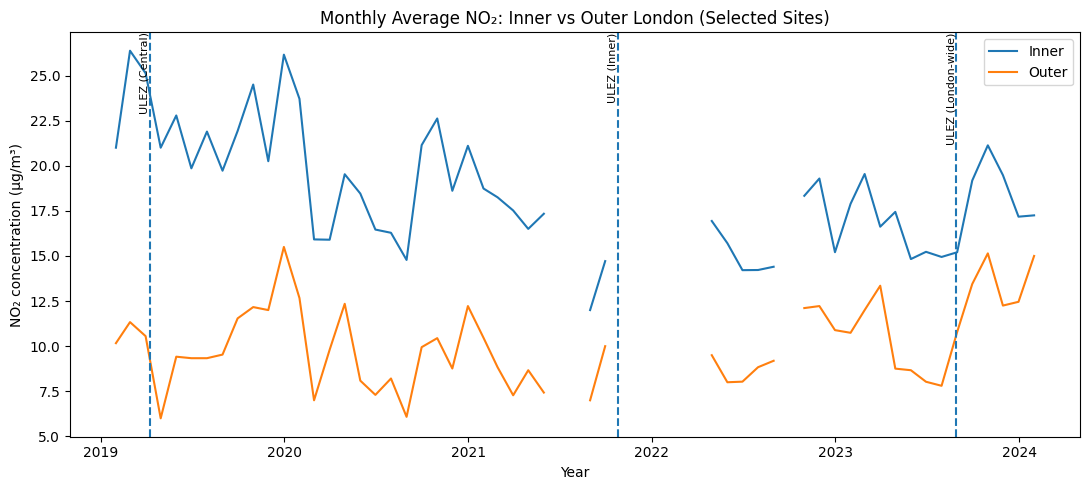


Rows used: 3503
Date range: 2019-01-13 16:00:00 to 2024-01-01 20:00:00

Observations per site:
site
London N. Kensington                 335
London Haringey Priory Park South    333
Tower Hamlets Roadside               333
London Harlington                    332
London Bexley                        330
London Hillingdon                    329
London Marylebone Road               320
London Westminster                   315
Haringey Roadside                    314
London Bloomsbury                    313
London Eltham                        249
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



RAW_PATH = "Nitrogen.csv"

INNER_SITES = [
    "Camden Kerbside",
    "London Bloomsbury",
    "London Hillingdon",
    "Haringey Roadside",
    "London Marylebone Road",
    "London Westminster",
    "London Haringey Priory Park South",
    "London Harlington",
    "London N. Kensington","Tower Hamlets Roadside"
]

OUTER_SITES = [
    "London Bexley",
    "London Eltham",
    "London Harlington"
]

ULEZ_LINES = [
    ("2019-04-08", "ULEZ (Central)"),
    ("2021-10-25", "ULEZ (Inner)"),
    ("2023-08-29", "ULEZ (London-wide)"),
]



raw = pd.read_csv(
    RAW_PATH,
    skiprows=3,
    header=None,
    engine="python",
    on_bad_lines="skip"
)



site_row = raw.iloc[0]
header_row = raw.iloc[1]


date_col = 0
time_col = 1


data = raw.iloc[2:].copy()


new_cols = []
for j in range(raw.shape[1]):
    if j == date_col:
        new_cols.append("date")
    elif j == time_col:
        new_cols.append("time")
    else:
        site_name = site_row.iloc[j]
        head_name = header_row.iloc[j]


        if pd.notna(site_name) and str(site_name).strip() != "":
            site_name = str(site_name).strip()
        else:
            site_name = None

        if isinstance(head_name, str) and "Status" in head_name:

            if site_name is None:
                new_cols.append(f"status_col_{j}")
            else:
                new_cols.append(f"{site_name}__status")
        else:

            if site_name is None:
                new_cols.append(f"value_col_{j}")
            else:
                new_cols.append(f"{site_name}__value")

data.columns = new_cols


data["datetime"] = pd.to_datetime(data["date"].astype(str) + " " + data["time"].astype(str), errors="coerce")
data = data.dropna(subset=["datetime"])

value_cols = [c for c in data.columns if c.endswith("__value")]

for c in value_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")

tidy = data[["datetime"] + value_cols].melt(
    id_vars="datetime",
    var_name="site",
    value_name="no2"
).dropna(subset=["no2"])

tidy["site"] = tidy["site"].str.replace("__value", "", regex=False)



SITE_AREA = {s: "Inner" for s in INNER_SITES}
SITE_AREA.update({s: "Outer" for s in OUTER_SITES})

available_sites = set(tidy["site"].unique())
wanted_sites = set(SITE_AREA.keys())
missing = sorted(list(wanted_sites - available_sites))
if missing:
    print("⚠️ These sites were NOT found in the CSV (check spelling):")
    for m in missing:
        print(" -", m)

tidy = tidy[tidy["site"].isin(SITE_AREA.keys())].copy()
tidy["area"] = tidy["site"].map(SITE_AREA)



monthly = (
    tidy
    .set_index("datetime")
    .groupby(["area", "site"])
    .resample("M")["no2"]
    .mean()
    .reset_index()
)

area_monthly = (
    monthly
    .groupby(["area", "datetime"])["no2"]
    .mean()
    .reset_index()
)



fig, ax = plt.subplots(figsize=(11, 5))

for area in ["Inner", "Outer"]:
    sub = area_monthly[area_monthly["area"] == area].sort_values("datetime")
    ax.plot(sub["datetime"], sub["no2"], label=area)

ymax = ax.get_ylim()[1]

for date_str, label in ULEZ_LINES:
    x = pd.to_datetime(date_str)
    ax.axvline(x, linestyle="--")
    ax.text(x, ymax, label, rotation=90, va="top", ha="right", fontsize=8)

ax.set_title("Monthly Average NO₂: Inner vs Outer London (Selected Sites)")
ax.set_xlabel("Year")
ax.set_ylabel("NO₂ concentration (µg/m³)")
ax.legend()

plt.tight_layout()
plt.show()


print("\nRows used:", len(tidy))
print("Date range:", tidy["datetime"].min(), "to", tidy["datetime"].max())
print("\nObservations per site:")
print(tidy["site"].value_counts())


In [ ]:

area_monthly[area_monthly["no2"].isna()].sort_values(["area","datetime"]).head(50)

monthly_counts = (
    tidy.set_index("datetime")
        .groupby(["area","site"])
        .resample("M")["no2"]
        .count()
        .reset_index(name="n_obs")
)


monthly_counts[monthly_counts["n_obs"] == 0].sort_values(["area","site","datetime"]).head(80)



In [ ]:
pip install folium pandas

In [ ]:
import pandas as pd
import geopandas as gpd
import folium


ulez_2019 = gpd.read_file("CentralUltraLowEmissionZone.gpkg")
ulez_2021 = gpd.read_file("InnerUltraLowEmissionZone.gpkg")
ulez_2023 = gpd.read_file("Ultra_Low_Emission_Zone_-9183899184828297755.geojson")


target_crs = "EPSG:4326"
if ulez_2019.crs is not None and ulez_2019.crs.to_string() != target_crs:
    ulez_2019 = ulez_2019.to_crs(target_crs)
if ulez_2021.crs is not None and ulez_2021.crs.to_string() != target_crs:
    ulez_2021 = ulez_2021.to_crs(target_crs)
if ulez_2023.crs is not None and ulez_2023.crs.to_string() != target_crs:
    ulez_2023 = ulez_2023.to_crs(target_crs)


file_path = "Nitrogen.csv"

meta = pd.read_csv(file_path, header=None, nrows=6)

site_row = meta.iloc[3]
lat_row  = meta.iloc[4]
lon_row  = meta.iloc[5]

sites = []
for col in meta.columns[1:]:
    name = site_row[col]
    if isinstance(name, str) and name.strip() != "":
        try:
            lat = float(lat_row[col])
            lon = float(lon_row[col])
            sites.append({"site_name": name.strip(), "latitude": lat, "longitude": lon})
        except:
            pass

sites_df = pd.DataFrame(sites)

print("Number of sites parsed:", len(sites_df))
print(sites_df.head())


if len(sites_df) > 0:
    center_lat = sites_df["latitude"].mean()
    center_lon = sites_df["longitude"].mean()
else:
    center_lat, center_lon = 51.5074, -0.1278

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles=None
)

folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Satellite",
    overlay=False
).add_to(m)


folium.GeoJson(
    ulez_2019,
    name="ULEZ 2019 – Central London",
    style_function=lambda x: {
        "fillColor": "#e41a1c",
        "color": "#e41a1c",
        "weight": 3,
        "fillOpacity": 0.25
    }
).add_to(m)

folium.GeoJson(
    ulez_2021,
    name="ULEZ 2021 (Inner London)",
    style_function=lambda x: {
        "fillColor": "#377eb8",
        "color": "#377eb8",
        "weight": 2,
        "fillOpacity": 0.25
    }
).add_to(m)

folium.GeoJson(
    ulez_2023,
    name="ULEZ 2023 (London-wide)",
    style_function=lambda x: {
        "fillColor": "#4daf4a",
        "color": "#4daf4a",
        "weight": 2,
        "fillOpacity": 0.20
    }
).add_to(m)


for _, row in sites_df.iterrows():
    popup_html = f"""
    <b>{row['site_name']}</b><br>
    Lat: {row['latitude']:.6f}<br>
    Lon: {row['longitude']:.6f}
    """
    folium.Circle(
        location=[row["latitude"], row["longitude"]],
        radius=800,
        color="white",
        weight=2,
        fill=True,
        fill_opacity=0.35,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)


folium.LayerControl(collapsed=False).add_to(m)

out_html = "ulez_plus_sites_satellite.html"
m.save(out_html)
print(f"Saved: {out_html}")

m

In [ ]:
import pandas as pd
from ipyleaflet import Map, Circle, Marker, Popup, basemaps
from ipywidgets import HTML

file_path = "Nitrogen.csv"


meta = pd.read_csv(file_path, header=None, nrows=6)

site_row = meta.iloc[3]
lat_row  = meta.iloc[4]
lon_row  = meta.iloc[5]


sites = []
for col in meta.columns[1:]:
    name = site_row[col]
    if isinstance(name, str) and name.strip() != "":
        try:
            lat = float(lat_row[col])
            lon = float(lon_row[col])
            sites.append({"site_name": name.strip(), "latitude": lat, "longitude": lon})
        except:
            pass

sites_df = pd.DataFrame(sites)


with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
    n_lines = sum(1 for _ in f)

print("File lines:", n_lines)
print("Number of sites parsed:", len(sites_df))
print(sites_df.head())


satellite_map = Map(
    center=(sites_df["latitude"].mean(), sites_df["longitude"].mean()),
    zoom=10,
    basemap=basemaps.Esri.WorldImagery
)


for _, row in sites_df.iterrows():
    html = HTML(f"<b>{row['site_name']}</b><br>Lat: {row['latitude']:.6f}<br>Lon: {row['longitude']:.6f}")
    popup = Popup(location=(row["latitude"], row["longitude"]), child=html, close_button=True)

    point = Circle(
        location=(row["latitude"], row["longitude"]),
        radius=800,
        color="white",
        fill=True,
        fill_opacity=0.35
    )
    satellite_map.add_layer(point)
    satellite_map.add_layer(popup)

satellite_map


In [ ]:
output_path = "sites_map.html"
satellite_map.save(output_path)

print(f"Map saved to {output_path}")

Map saved to sites_map.html


In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path


PM25_PRE_PATH  = "PM2.5 2013.csv"
PM25_POST_PATH = "Pm2.5 (2).csv"


RUN_NO2 = True
NO2_PRE_PATH   = "No2 2013.csv"
NO2_POST_PATH  = "Nitrogen.csv"


CUTOFF = pd.Timestamp("2019-01-01")


OUT_DIR = Path("ukair_outputs")
OUT_DIR.mkdir(exist_ok=True)


def read_csv_ragged(path: str) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8", errors="replace", newline="") as f:
        reader = csv.reader(f)
        for r in reader:
            rows.append(r)
    maxlen = max(len(r) for r in rows)
    rows_padded = [r + [None] * (maxlen - len(r)) for r in rows]
    return pd.DataFrame(rows_padded)

def find_header_row(raw: pd.DataFrame) -> int:

    for i in range(len(raw)):
        row = raw.iloc[i].astype(str).tolist()
        if any(cell == "Date" for cell in row):

            if row[0] == "Date" or "Date" in row[:3]:
                return i
    raise ValueError("Could not find header row with 'Date' in the file.")

def make_unique(cols):
    seen = {}
    out = []
    for c in cols:
        c = str(c) if c is not None else ""
        if c in seen:
            seen[c] += 1
            out.append(f"{c}__{seen[c]}")
        else:
            seen[c] = 0
            out.append(c)
    return out


def parse_ukair_table(path: str, has_time: bool) -> pd.DataFrame:
    """
    Returns a long time series with:
      datetime, value_mean (avg across all site columns), n_sites
    """
    raw = read_csv_ragged(path)
    h = find_header_row(raw)

    header_raw = raw.iloc[h].tolist()
    header = make_unique(header_raw)

    data = raw.iloc[h + 1 :].copy()
    data.columns = header
    data = data.dropna(how="all")

    if "Date" not in data.columns:
        raise ValueError(f"No 'Date' column after parsing: {path}")


    if has_time:
        if "Time" not in data.columns:
            raise ValueError(f"Expected a 'Time' column for hourly file: {path}")
        data["datetime"] = pd.to_datetime(
            data["Date"].astype(str) + " " + data["Time"].astype(str),
            errors="coerce",
        )
        data = data.drop(columns=["Date", "Time"])
    else:
        data["datetime"] = pd.to_datetime(data["Date"], errors="coerce")
        data = data.drop(columns=["Date"])


    value_cols = [c for c in data.columns if c != "datetime" and "Status" not in c]
    vals = (
        data[value_cols]
        .replace({"No data": np.nan, "No Data": np.nan, "": np.nan})
        .apply(pd.to_numeric, errors="coerce")
    )

    out = pd.DataFrame({"datetime": data["datetime"]})
    out["value_mean"] = vals.mean(axis=1, skipna=True)
    out["n_sites"] = vals.notna().sum(axis=1)
    out = out.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)
    return out


def hourly_to_daily(ts: pd.DataFrame) -> pd.DataFrame:
    df = ts.copy()
    df["date"] = df["datetime"].dt.floor("D")
    d = df.groupby("date", as_index=False).agg(
        value_mean=("value_mean", "mean"),
        avg_n_sites=("n_sites", "mean"),
        n_obs=("value_mean", "count"),
    )
    d = d.rename(columns={"date": "datetime"})
    return d

def daily_to_monthly(ts_daily: pd.DataFrame) -> pd.DataFrame:
    df = ts_daily.copy()
    df["year_month"] = df["datetime"].dt.to_period("M").dt.to_timestamp()
    m = df.groupby("year_month", as_index=False).agg(
        value_mean=("value_mean", "mean"),
        n_obs=("value_mean", "count"),
    )
    return m


def prepost_summary(monthly: pd.DataFrame, cutoff=CUTOFF) -> pd.DataFrame:
    df = monthly.copy()
    df["post_2019"] = (df["year_month"] >= cutoff).astype(int)
    return (
        df.groupby("post_2019")["value_mean"]
        .agg(mean="mean", median="median", std="std", n_months="count")
        .reset_index()
    )

def its_regression(monthly: pd.DataFrame, cutoff=CUTOFF):
    """
    ITS model:
      y_t = b0 + b1*t + b2*post + b3*(t*post) + e
    """
    df = monthly.sort_values("year_month").dropna(subset=["value_mean"]).copy()
    df["t"] = range(len(df))
    df["post"] = (df["year_month"] >= cutoff).astype(int)
    df["t_post"] = df["t"] * df["post"]

    X = sm.add_constant(df[["t", "post", "t_post"]])
    y = df["value_mean"]
    model = sm.OLS(y, X).fit()

    coef = pd.DataFrame(
        {"term": model.params.index, "coef": model.params.values, "p_value": model.pvalues.values}
    )
    return model, coef, df

def plot_monthly(monthly: pd.DataFrame, title: str, ylab: str, outpath: Path, cutoff=CUTOFF):
    plt.figure(figsize=(10, 4))
    plt.plot(monthly["year_month"], monthly["value_mean"])
    plt.axvline(cutoff, linestyle="--")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(ylab)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()



print("=== PM2.5: loading pre (daily mean) and post (hourly) ===")
pm25_pre_daily_raw  = parse_ukair_table(PM25_PRE_PATH,  has_time=False)
pm25_post_hourly    = parse_ukair_table(PM25_POST_PATH, has_time=False)


pm25_pre_daily = pm25_pre_daily_raw[["datetime", "value_mean", "n_sites"]].copy()


pm25_post_daily = hourly_to_daily(pm25_post_hourly)
pm25_post_daily = pm25_post_daily.rename(columns={"avg_n_sites": "n_sites"})


pm25_daily_all = pd.concat(
    [
        pm25_pre_daily[["datetime", "value_mean"]],
        pm25_post_daily[["datetime", "value_mean"]],
    ],
    ignore_index=True,
).dropna(subset=["datetime"])

pm25_monthly_all = daily_to_monthly(pm25_daily_all)


pm25_monthly_all.to_csv(OUT_DIR / "pm25_monthly_processed.csv", index=False)


pm25_sum = prepost_summary(pm25_monthly_all, cutoff=CUTOFF)
pm25_sum.to_csv(OUT_DIR / "pm25_prepost_summary.csv", index=False)


pm25_model, pm25_coef, pm25_regdf = its_regression(pm25_monthly_all, cutoff=CUTOFF)
pm25_coef.to_csv(OUT_DIR / "pm25_its_coefficients.csv", index=False)


plot_monthly(
    pm25_monthly_all,
    title="Monthly mean PM2.5 (avg across sites) — pre vs post 2019",
    ylab="PM2.5 (µg/m³)",
    outpath=OUT_DIR / "pm25_monthly.png",
    cutoff=CUTOFF,
)

print("\n=== PM2.5 DONE ===")
print("Pre/Post summary:")
print(pm25_sum)
print("\nITS coefficients:")
print(pm25_coef)
print("\nSaved outputs to:", OUT_DIR.resolve())

=== PM2.5: loading pre (daily mean) and post (hourly) ===

=== PM2.5 DONE ===
Pre/Post summary:
   post_2019       mean     median       std  n_months
0          0  12.340222  11.140462  3.963926        60
1          1   9.213370   8.675627  3.211656        61

ITS coefficients:
     term       coef       p_value
0   const  14.106428  4.565616e-31
1       t  -0.059871  2.253787e-02
2    post   0.555400  8.232166e-01
3  t_post  -0.000667  9.853220e-01

Saved outputs to: /content/ukair_outputs


In [ ]:
from IPython.display import Image, display
display(Image("/content/ukair_outputs/pm25_monthly.png"))

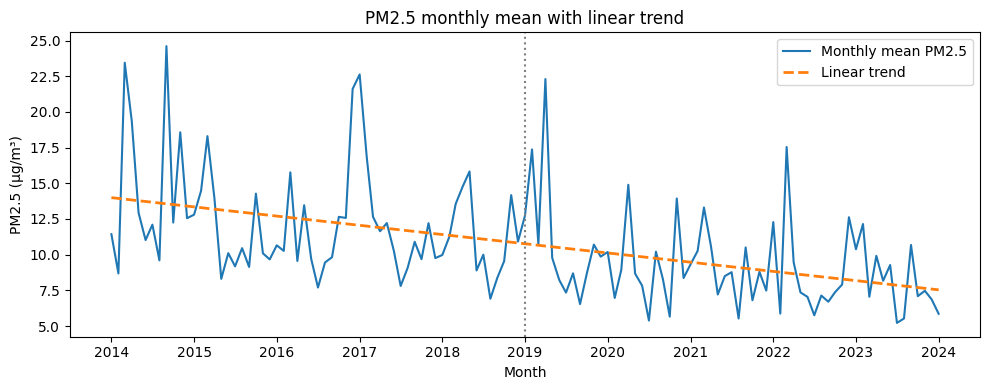

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


df = pm25_monthly_all.copy().dropna(subset=["value_mean"])


df["t"] = np.arange(len(df))

coef = np.polyfit(df["t"], df["value_mean"], 1)
trend = np.polyval(coef, df["t"])

plt.figure(figsize=(10,4))
plt.plot(df["year_month"], df["value_mean"], label="Monthly mean PM2.5")
plt.plot(df["year_month"], trend, linestyle="--", linewidth=2,
         label="Linear trend")

plt.axvline(pd.Timestamp("2019-01-01"), linestyle=":", color="grey")
plt.title("PM2.5 monthly mean with linear trend")
plt.xlabel("Month")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()


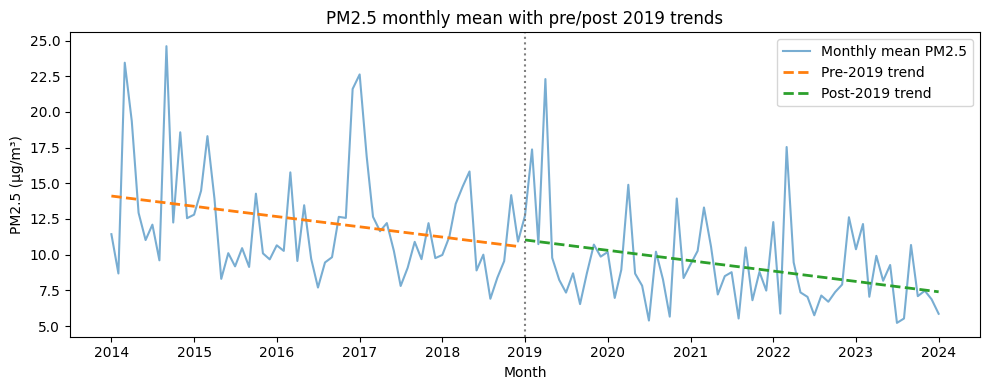

In [ ]:
df = pm25_monthly_all.copy().dropna(subset=["value_mean"])

pre = df[df["year_month"] < "2019-01-01"].copy()
post = df[df["year_month"] >= "2019-01-01"].copy()

pre["t"] = np.arange(len(pre))
post["t"] = np.arange(len(post))

coef_pre = np.polyfit(pre["t"], pre["value_mean"], 1)
coef_post = np.polyfit(post["t"], post["value_mean"], 1)

pre_trend = np.polyval(coef_pre, pre["t"])
post_trend = np.polyval(coef_post, post["t"])

plt.figure(figsize=(10,4))
plt.plot(df["year_month"], df["value_mean"], label="Monthly mean PM2.5", alpha=0.6)

plt.plot(pre["year_month"], pre_trend, linestyle="--", linewidth=2,
         label="Pre-2019 trend")
plt.plot(post["year_month"], post_trend, linestyle="--", linewidth=2,
         label="Post-2019 trend")

plt.axvline(pd.Timestamp("2019-01-01"), linestyle=":", color="grey")
plt.title("PM2.5 monthly mean with pre/post 2019 trends")
plt.xlabel("Month")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

b_t = pm25_model.params["t"]
b_t_post = pm25_model.params["t_post"]

slope_pre = b_t
slope_post = b_t + b_t_post

print(f"Pre-2019 slope (ITS):  {slope_pre:.4f} µg/m³ per month")
print(f"Post-2019 slope (ITS): {slope_post:.4f} µg/m³ per month")

print(f"Pre-2019 annual change:  {slope_pre*12:.2f} µg/m³ per year")
print(f"Post-2019 annual change: {slope_post*12:.2f} µg/m³ per year")


In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

NO2_PRE_PATH  = "No2 2013.csv"
NO2_POST_PATH = "Nitrogen.csv"


OUT_DIR = Path("ukair_outputs_no2")
OUT_DIR.mkdir(exist_ok=True)

ULEZ_2019 = pd.Timestamp("2019-04-08")
ULEZ_2021 = pd.Timestamp("2021-10-25")
ULEZ_2023 = pd.Timestamp("2023-08-29")

ITS_CUTOFF = ULEZ_2019


def read_csv_ragged(path: str) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8", errors="replace", newline="") as f:
        reader = csv.reader(f)
        for r in reader:
            rows.append(r)
    maxlen = max(len(r) for r in rows)
    rows = [r + [None] * (maxlen - len(r)) for r in rows]
    return pd.DataFrame(rows)

def find_header_row(raw: pd.DataFrame) -> int:
    for i in range(len(raw)):
        row = raw.iloc[i].astype(str).tolist()
        if any(cell == "Date" for cell in row):
            if row[0] == "Date" or "Date" in row[:3]:
                return i
    raise ValueError("Could not find header row containing 'Date'.")

def make_unique(cols):
    seen = {}
    out = []
    for c in cols:
        c = str(c) if c is not None else ""
        if c in seen:
            seen[c] += 1
            out.append(f"{c}__{seen[c]}")
        else:
            seen[c] = 0
            out.append(c)
    return out



def parse_ukair_timeseries(path: str, has_time: bool) -> pd.DataFrame:
    """
    Returns:
      datetime, value_mean, n_sites
    value_mean is the mean across all numeric site columns in that row.
    """
    raw = read_csv_ragged(path)
    h = find_header_row(raw)

    header_raw = raw.iloc[h].tolist()
    header = make_unique(header_raw)

    data = raw.iloc[h + 1 :].copy()
    data.columns = header
    data = data.dropna(how="all")

    if "Date" not in data.columns:
        raise ValueError(f"No Date column found after parsing: {path}")


    if has_time:
        if "Time" not in data.columns:
            raise ValueError(f"Expected a Time column for hourly file: {path}")
        data["datetime"] = pd.to_datetime(
            data["Date"].astype(str) + " " + data["Time"].astype(str),
            errors="coerce",
        )
        data = data.drop(columns=["Date", "Time"])
    else:

        data["datetime"] = pd.to_datetime(data["Date"], errors="coerce")
        data = data.drop(columns=["Date"])

    value_cols = [c for c in data.columns if c != "datetime" and "Status" not in c]
    vals = (
        data[value_cols]
        .replace({"No data": np.nan, "No Data": np.nan, "": np.nan})
        .apply(pd.to_numeric, errors="coerce")
    )

    out = pd.DataFrame({"datetime": data["datetime"]})
    out["value_mean"] = vals.mean(axis=1, skipna=True)
    out["n_sites"] = vals.notna().sum(axis=1)

    out = out.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)
    return out


def hourly_to_daily(ts_hourly: pd.DataFrame) -> pd.DataFrame:
    df = ts_hourly.copy()
    df["date"] = df["datetime"].dt.floor("D")
    daily = df.groupby("date", as_index=False).agg(
        value_mean=("value_mean", "mean"),
        n_obs=("value_mean", "count"),
        avg_n_sites=("n_sites", "mean"),
    )
    daily = daily.rename(columns={"date": "datetime"})
    return daily

def daily_to_monthly(ts_daily: pd.DataFrame) -> pd.DataFrame:
    df = ts_daily.copy()
    df["year_month"] = df["datetime"].dt.to_period("M").dt.to_timestamp()
    monthly = df.groupby("year_month", as_index=False).agg(
        value_mean=("value_mean", "mean"),
        n_days=("value_mean", "count"),
    )
    return monthly



def plot_monthly_with_milestones(monthly: pd.DataFrame, outpath: Path):
    plt.figure(figsize=(11,4))
    plt.plot(monthly["year_month"], monthly["value_mean"], label="Monthly mean NO₂")
    plt.axvline(ULEZ_2019, linestyle="--", label="ULEZ central (2019)")
    plt.axvline(ULEZ_2021, linestyle="--", label="ULEZ inner (2021)")
    plt.axvline(ULEZ_2023, linestyle="--", label="ULEZ London-wide (2023)")
    plt.title("NO₂ monthly mean (avg across sites) with ULEZ milestones")
    plt.xlabel("Month")
    plt.ylabel("NO₂ (µg/m³)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()

def plot_prepost_trends(monthly: pd.DataFrame, cutoff: pd.Timestamp, outpath: Path):
    df = monthly.dropna(subset=["value_mean"]).sort_values("year_month").copy()
    pre = df[df["year_month"] < cutoff].copy()
    post = df[df["year_month"] >= cutoff].copy()

    if len(pre) < 2 or len(post) < 2:
        print("Not enough pre/post months for trend lines.")
        return

    pre["t"] = np.arange(len(pre))
    post["t"] = np.arange(len(post))

    slope_pre, intercept_pre = np.polyfit(pre["t"], pre["value_mean"], 1)
    slope_post, intercept_post = np.polyfit(my := post["t"], post["value_mean"], 1)

    pre_trend = intercept_pre + slope_pre * pre["t"]
    post_trend = intercept_post + slope_post * post["t"]

    plt.figure(figsize=(11,4))
    plt.plot(df["year_month"], df["value_mean"], label="Monthly mean NO₂", alpha=0.7)
    plt.plot(pre["year_month"], pre_trend, linestyle="--", linewidth=2, label="Pre-cutoff trend")
    plt.plot(post["year_month"], post_trend, linestyle="--", linewidth=2, label="Post-cutoff trend")
    plt.axvline(cutoff, linestyle=":", color="grey", label=f"Cutoff: {cutoff.date()}")
    plt.title("NO₂ monthly mean with pre/post trend lines")
    plt.xlabel("Month")
    plt.ylabel("NO₂ (µg/m³)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()


def its_regression(monthly: pd.DataFrame, cutoff: pd.Timestamp):
    df = monthly.dropna(subset=["value_mean"]).sort_values("year_month").copy()
    df["t"] = np.arange(len(df))
    df["post"] = (df["year_month"] >= cutoff).astype(int)
    df["t_post"] = df["t"] * df["post"]

    X = sm.add_constant(df[["t", "post", "t_post"]])
    y = df["value_mean"]

    model = sm.OLS(y, X).fit()

    coef = pd.DataFrame({
        "term": model.params.index,
        "coef": model.params.values,
        "p_value": model.pvalues.values
    })


    slope_pre = model.params["t"]
    slope_post = model.params["t"] + model.params["t_post"]

    return model, coef, slope_pre, slope_post



print("=== Load + parse NO₂ PRE (daily mean) ===")
no2_pre = parse_ukair_timeseries(NO2_PRE_PATH, has_time=False)

print("=== Load + parse NO₂ POST (hourly) ===")
no2_post_hourly = parse_ukair_timeseries(NO2_POST_PATH, has_time=False)


no2_post_daily = no2_post_hourly


no2_daily_all = pd.concat(
    [no2_pre[["datetime", "value_mean"]], no2_post_daily[["datetime", "value_mean"]]],
    ignore_index=True
).dropna(subset=["datetime"])


no2_monthly_all = daily_to_monthly(no2_daily_all)


no2_monthly_all.to_csv(OUT_DIR / "no2_monthly_processed.csv", index=False)


tmp = no2_monthly_all.copy()
tmp["post"] = (tmp["year_month"] >= ITS_CUTOFF).astype(int)
no2_summary = tmp.groupby("post")["value_mean"].agg(
    mean="mean", median="median", std="std", n_months="count"
).reset_index()
no2_summary.to_csv(OUT_DIR / "no2_prepost_summary.csv", index=False)

print("\nPre/Post summary (cutoff = %s):" % ITS_CUTOFF.date())
print(no2_summary)


plot_monthly_with_milestones(no2_monthly_all, OUT_DIR / "no2_monthly_with_ulez.png")
plot_prepost_trends(no2_monthly_all, ITS_CUTOFF, OUT_DIR / "no2_prepost_trends.png")

print("\nSaved plots:")
print(" -", (OUT_DIR / "no2_monthly_with_ulez.png").resolve())
print(" -", (OUT_DIR / "no2_prepost_trends.png").resolve())


print("\n=== ITS regression (single breakpoint) ===")
model, coef, slope_pre, slope_post = its_regression(no2_monthly_all, ITS_CUTOFF)
coef.to_csv(OUT_DIR / "no2_its_coefficients.csv", index=False)

print(coef)
print("\nImplied slopes:")
print(f"Pre-cutoff slope:  {slope_pre:.4f} µg/m³ per month  ({slope_pre*12:.2f} per year)")
print(f"Post-cutoff slope: {slope_post:.4f} µg/m³ per month  ({slope_post*12:.2f} per year)")

print("\nSaved outputs to:", OUT_DIR.resolve())

=== Load + parse NO₂ PRE (daily mean) ===
=== Load + parse NO₂ POST (hourly) ===

Pre/Post summary (cutoff = 2019-04-08):
   post       mean     median       std  n_months
0     0  41.983246  41.266889  6.951329        64
1     1  25.888295  25.800214  5.570280        57

Saved plots:
 - /content/ukair_outputs_no2/no2_monthly_with_ulez.png
 - /content/ukair_outputs_no2/no2_prepost_trends.png

=== ITS regression (single breakpoint) ===
     term       coef       p_value
0   const  45.975552  4.723973e-58
1       t  -0.126740  2.374139e-03
2    post -10.194026  3.484390e-02
3  t_post   0.019205  7.625092e-01

Implied slopes:
Pre-cutoff slope:  -0.1267 µg/m³ per month  (-1.52 per year)
Post-cutoff slope: -0.1075 µg/m³ per month  (-1.29 per year)

Saved outputs to: /content/ukair_outputs_no2
